<a href="https://colab.research.google.com/github/dhairya-eng/LSTM-and-MLP-Pytorch/blob/main/StockmarketpredictionMLP%26LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import numpy as np


In [ ]:
# Fetch last 5 years of daily data
ticker = "AAPL"
data = yf.download(ticker, period="5y", interval="1d").reset_index()

print(data.head())


/tmp/ipython-input-6-1983635048.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="5y", interval="1d").reset_index()
[*********************100%***********************]  1 of 1 completed

Price        Date       Close        High        Low        Open     Volume
Ticker                   AAPL        AAPL       AAPL        AAPL       AAPL
0      2020-07-27   92.161858   92.254205  90.869011   91.092583  121214000
1      2020-07-28   90.647881   91.909141  90.643015   91.731736  103625600
2      2020-07-29   92.385452   92.570148  91.095031   91.131482   90329200
3      2020-07-30   93.503334   93.607830  91.148496   91.556763  158130000
4      2020-07-31  103.292061  103.442730  98.008860  100.011328  374336800


In [ ]:
# normalizing the data before passing to the class below
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
def create_dataset(df, lookback=10):
    X, y = [], []
    for i in range(len(df) - lookback):
        features = df[['Open', 'High', 'Low', 'Close', 'Volume']].iloc[i:i+lookback].values.flatten()
        target = df['Close'].iloc[i+lookback]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y)

X, y = create_dataset(data, lookback=10)

# 3) Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = y.reshape(-1, 1)
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y)
# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)

In [ ]:
# creating a customize dataset
import torch
from torch.utils.data import Dataset
import pandas as pd

class StockDataset(Dataset):
    def __init__(self, X,y):
        self.X=torch.tensor(X,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]

In [ ]:
from torch.utils.data import DataLoader

train_data=StockDataset(X_train,y_train)
test_data=StockDataset(X_test,y_test)

train_loader=DataLoader(train_data,batch_size=32,shuffle=False)
test_loader=DataLoader(test_data,batch_size=32,shuffle=False)

for X_batch,y_batch in train_loader:
    print(X_batch.shape,y_batch.shape)
    break

torch.Size([32, 50]) torch.Size([32, 1])


In [ ]:
# creating a neural network using MLP
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  def __init__(self):
    super(Model,self).__init__()
    self.fc1=nn.Linear(50,128)
    self.fc2=nn.Linear(128,64)
    self.fc3=nn.Linear(64,1)
  def forward(self,x):
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=self.fc3(x)
    return x

In [ ]:
model = Model()
sample_input = torch.randn(32, 50)   # batch_size=32, features=50
output = model(sample_input)
print(output.shape)

torch.Size([32, 1])


Epoch 1/40, Loss: 0.007088316138833761
Epoch 2/40, Loss: 0.07965334504842758
Epoch 3/40, Loss: 0.030567511916160583
Epoch 4/40, Loss: 0.466521292924881
Epoch 5/40, Loss: 0.5302352905273438
Epoch 6/40, Loss: 1.3853411674499512
Epoch 7/40, Loss: 0.02885008417069912
Epoch 8/40, Loss: 0.3410414755344391
Epoch 9/40, Loss: 0.7475727200508118
Epoch 10/40, Loss: 0.33175748586654663
Epoch 11/40, Loss: 0.26415032148361206
Epoch 12/40, Loss: 1.228865385055542
Epoch 13/40, Loss: 0.08762289583683014
Epoch 14/40, Loss: 0.03167625144124031
Epoch 15/40, Loss: 0.009700598195195198
Epoch 16/40, Loss: 0.3421386182308197
Epoch 17/40, Loss: 0.014798128977417946
Epoch 18/40, Loss: 0.4153539538383484
Epoch 19/40, Loss: 0.009039318189024925
Epoch 20/40, Loss: 1.3343658447265625
Epoch 21/40, Loss: 0.09743636846542358
Epoch 22/40, Loss: 0.032044995576143265
Epoch 23/40, Loss: 0.06854408234357834
Epoch 24/40, Loss: 0.02354741469025612
Epoch 25/40, Loss: 0.012648440897464752
Epoch 26/40, Loss: 0.7479602098464966


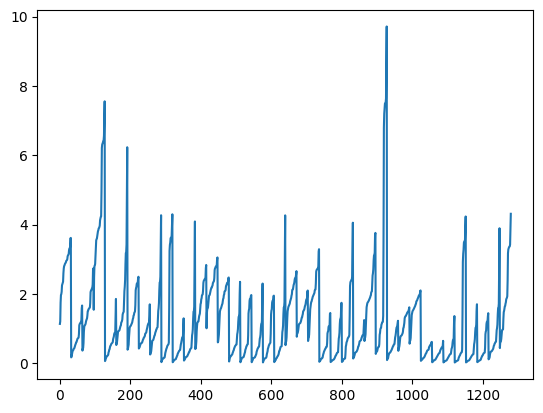

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
model=Model()
loss=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.005)

epochs=40
lo=[]
for epoch in range(epochs):
  total_loss=0
  for X_batch,y_batch in train_loader:
    optimizer.zero_grad()
    y_pred=model(X_batch)
    l=loss(y_pred,y_batch)
    l.backward()
    optimizer.step()
    total_loss+=l.item()
    lo.append(total_loss)
  print(f"Epoch {epoch+1}/{epochs}, Loss: {l.item()}")

print("Training complete!")
plt.plot(lo)

In [ ]:
model.eval()


Model(
  (fc1): Linear(in_features=50, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

Predicted (first 10): tensor([0.8156, 0.7982, 0.7624, 0.7283, 0.7223, 0.7212, 0.7657, 0.7587, 0.7461,
        0.6974])
Actual (first 10):    tensor([[1.3481],
        [1.3558],
        [1.3713],
        [1.4617],
        [1.3592],
        [1.4005],
        [1.1086],
        [1.0524],
        [1.1238],
        [1.2200]])


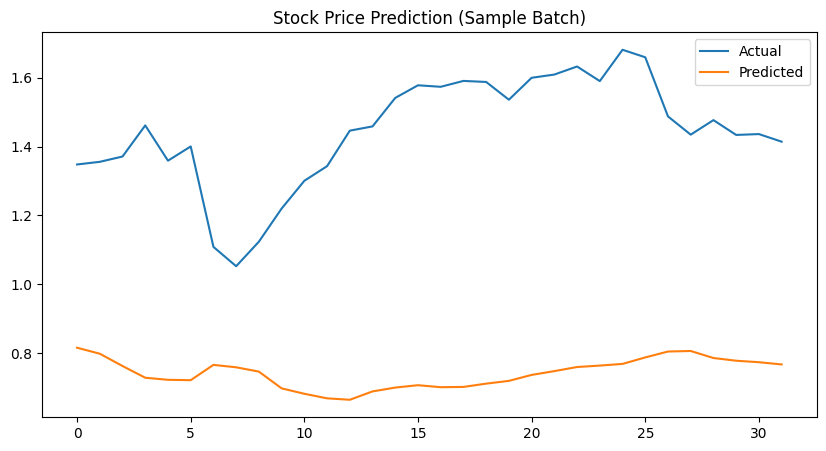

In [ ]:
import matplotlib.pyplot as plt

# Take one batch from test_loader
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze()
        break

print("Predicted (first 10):", y_pred[:10])
print("Actual (first 10):   ", y_batch[:10])
plt.figure(figsize=(10,5))
plt.plot(y_batch[:50].numpy(), label="Actual")
plt.plot(y_pred[:50].numpy(), label="Predicted")
plt.legend()
plt.title("Stock Price Prediction (Sample Batch)")
plt.show()


LSTM Method

In [ ]:
class StockDatasetLSTM(Dataset):
    def __init__(self, X, y):
        # reshape to (samples, sequence_length, features)
        self.X = torch.tensor(X.reshape(-1, 10, 5), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
train_data = StockDatasetLSTM(X_train, y_train)
test_data = StockDatasetLSTM(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Check shape
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break


torch.Size([32, 10, 5]) torch.Size([32, 1])


In [ ]:
class LSTMStockModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMStockModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        # out = self.bn(out[:, -1, :])
        out = self.fc(out[:, -1, :])
        return out



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Model, loss, optimizer
model = LSTMStockModel(input_size=5, hidden_size=64, num_layers=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


LSTMStockModel(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
import numpy as np

epochs = 40
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} Test Loss: {avg_test_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Epoch [1/40] Train Loss: 0.5933 Test Loss: 1.7699
Epoch [2/40] Train Loss: 0.1225 Test Loss: 0.8562
Epoch [3/40] Train Loss: 0.1040 Test Loss: 0.4645
Epoch [4/40] Train Loss: 0.0861 Test Loss: 0.1869
Epoch [5/40] Train Loss: 0.0878 Test Loss: 0.1274
Epoch [6/40] Train Loss: 0.0831 Test Loss: 0.1084
Epoch [7/40] Train Loss: 0.0879 Test Loss: 0.1109
Epoch [8/40] Train Loss: 0.0974 Test Loss: 0.1022
Epoch [9/40] Train Loss: 0.0953 Test Loss: 0.0983
Epoch [10/40] Train Loss: 0.0826 Test Loss: 0.1112
Epoch [11/40] Train Loss: 0.0690 Test Loss: 0.1108
Epoch [12/40] Train Loss: 0.0599 Test Loss: 0.1121
Epoch [13/40] Train Loss: 0.0685 Test Loss: 0.1277
Epoch [14/40] Train Loss: 0.0667 Test Loss: 0.1069
Epoch [15/40] Train Loss: 0.0747 Test Loss: 0.1755
Epoch [16/40] Train Loss: 0.0873 Test Loss: 0.1747
Epoch [17/40] Train Loss: 0.0662 Test Loss: 0.0845
Epoch [18/40] Train Loss: 0.0687 Test Loss: 0.1755
Epoch [19/40] Train Loss: 0.0740 Test Loss: 0.1470
Epoch [20/40] Train Loss: 0.0695 Test Lo

In [ ]:
model.eval()
import matplotlib.pyplot as plt

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch).squeeze()
        break

print("Predicted (first 10):", y_pred[:10])
print("Actual (first 10):   ", y_batch[:10])


Predicted (first 10): tensor([1.3048, 1.2717, 1.2381, 1.2188, 1.2236, 1.2367, 1.2722, 1.2452, 1.1807,
        1.1357])
Actual (first 10):    tensor([[1.3481],
        [1.3558],
        [1.3713],
        [1.4617],
        [1.3592],
        [1.4005],
        [1.1086],
        [1.0524],
        [1.1238],
        [1.2200]])


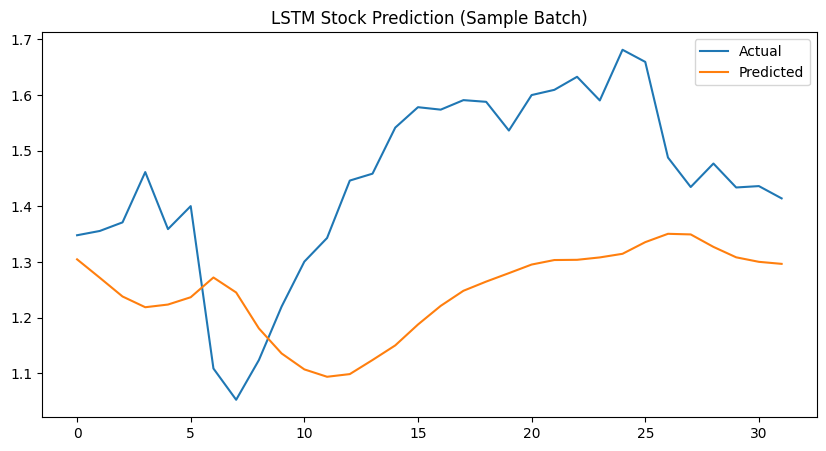

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_batch[:50].cpu().numpy(), label="Actual")
plt.plot(y_pred[:50].cpu().numpy(), label="Predicted")
plt.legend()
plt.title("LSTM Stock Prediction (Sample Batch)")
plt.show()
